In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder

In [7]:
log_shots = pd.read_csv('shot_logs.csv')

In [8]:
log_shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [9]:
# Convert GAME_CLOCK from 'MM:SS' to total seconds
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)

In [10]:
log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')


In [11]:
#Checking the correlation between numerical features
numerical_col = log_shots.select_dtypes(include = ['float64', 'int64','int32'])
corr = numerical_col.corr()
corr
#add a heat map in here

,GAME_ID,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,GAME_CLOCK_SECONDS
GAME_ID,1.000000,-0.005014,0.001726,0.008129,-0.008921,0.014530,0.002014,-0.000735,-0.000187,0.003418,-0.008761,0.028676,0.006739,-0.008761,-0.008464,0.027937,0.002803
LOCATION,-0.005014,1.000000,0.155075,-0.003267,0.003064,0.008083,-0.014873,-0.012914,-0.001589,0.005012,0.008093,-0.007922,0.003579,0.008093,0.009179,0.011302,0.001685
FINAL_MARGIN,0.001726,0.155075,1.000000,0.000836,-0.003078,-0.009276,0.011739,0.010788,0.008876,0.024134,0.058762,0.057165,0.033064,0.058762,0.064784,-0.050825,0.005975
SHOT_NUMBER,0.008129,-0.003267,0.000836,1.000000,0.654932,-0.032683,0.141100,0.144071,0.011541,0.003054,-0.008351,0.013257,-0.037769,-0.008351,-0.009666,-0.006592,-0.237956
PERIOD,-0.008921,0.003064,-0.003078,0.654932,1.000000,-0.051796,0.055301,0.046089,0.030080,0.048915,-0.014082,0.011462,-0.010204,-0.014082,-0.008501,0.004790,-0.027042
SHOT_CLOCK,0.014530,0.008083,-0.009276,-0.032683,-0.051796,1.000000,-0.082771,-0.147688,-0.173026,-0.032809,0.096855,-0.003289,0.026558,0.096855,0.084173,0.038315,0.021242
DRIBBLES,0.002014,-0.014873,0.011739,0.141100,0.055301,-0.082771,1.000000,0.914311,-0.082540,-0.169016,-0.034390,0.016915,-0.153674,-0.034390,-0.055689,0.023655,-0.116189
TOUCH_TIME,-0.000735,-0.012914,0.010788,0.144071,0.046089,-0.147688,0.914311,1.000000,-0.085165,-0.181007,-0.045299,0.016225,-0.164737,-0.045299,-0.066736,0.001797,-0.103308
SHOT_DIST,-0.000187,-0.001589,0.008876,0.011541,0.030080,-0.173026,-0.082540,-0.085165,1.000000,0.740933,-0.191704,0.002777,0.523192,-0.191704,-0.069147,-0.024270,-0.021729
PTS_TYPE,0.003418,0.005012,0.024134,0.003054,0.048915,-0.032809,-0.169016,-0.181007,0.740933,1.000000,-0.121293,0.006266,0.414198,-0.121293,0.030361,0.010486,-0.048474


In [12]:
# Select only the specified features for modeling
selected_features = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_SECONDS', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST']
log_shots_selected = log_shots[selected_features]
log_shots_selected.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,0,1,1,69,10.8,2,1.9,7.7,2,1.3
1,0,2,1,14,3.4,0,0.8,28.2,3,6.1
2,0,3,1,0,NaN,3,2.7,10.1,2,0.9
3,0,4,2,707,10.3,2,1.9,17.2,2,3.4
4,0,5,2,634,10.9,2,2.7,3.7,2,1.1


In [13]:
X = log_shots_selected[selected_features]
X.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,0,1,1,69,10.8,2,1.9,7.7,2,1.3
1,0,2,1,14,3.4,0,0.8,28.2,3,6.1
2,0,3,1,0,NaN,3,2.7,10.1,2,0.9
3,0,4,2,707,10.3,2,1.9,17.2,2,3.4
4,0,5,2,634,10.9,2,2.7,3.7,2,1.1


In [14]:
Y = log_shots['SHOT_RESULT']
Y.head()

0    1
1    0
2    0
3    0
4    0
Name: SHOT_RESULT, dtype: int32

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.2,
                                                    random_state = 33)

In [16]:
X_train.dtypes
X_train.head()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_SECONDS,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
4361,0,2,2,392,11.0,0,1.0,20.4,2,2.5
56099,0,7,4,632,12.2,0,0.9,19.0,2,6.7
95741,0,11,3,643,13.9,0,0.9,20.0,2,9.5
115089,0,10,4,472,13.9,0,1.0,26.1,3,4.8
40082,0,4,1,2,NaN,0,0.9,18.0,2,6.8


In [ ]:
#target encoding for categorical features
categorical_features = ['CLOSEST_DEFENDER','player_name']
encoder = TargetEncoder(
    cols=categorical_cols_to_encode,
    smoothing=0.2 # İyi bir başlangıç değeridir.
)

In [17]:
from sklearn.impute import SimpleImputer
# Replace the missing values in X_train and X_test
myimp = SimpleImputer()

imputed_X_train = pd.DataFrame(myimp.fit_transform(X_train))
imputed_X_test = pd.DataFrame(myimp.transform(X_test))

imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

X_train = imputed_X_train
X_test = imputed_X_test

In [19]:
import xgboost as xgb
from sklearn import metrics
# Changing the format
dtest = xgb.DMatrix(X_test)
d_train_xgboost = xgb.DMatrix(X_train,label = Y_train)

# Parameter of boosting
parameters={'max_depth':10, 
            'objective':'binary:logistic',
            'eval_metric':'auc',
            'learning_rate':.05}

plst = list(parameters.items())

In [21]:
# Training model
xgb_model = xgb.train(parameters, d_train_xgboost, 50)

In [22]:
y_pred_xgb = xgb_model.predict(dtest)
y_pred_xgb

array([0.49265614, 0.538848  , 0.6139137 , ..., 0.65777946, 0.20599645,
       0.43503043], shape=(25614,), dtype=float32)

In [23]:
# We here will assign values of y_pred_xgb to three values(0.5,1,0) because we do not want too many decimals and less distinct values will help us to predict.
for i in range(0, X_test.shape[0]): 
    if y_pred_xgb[i]>=.5:       # setting threshold to .5 
       y_pred_xgb[i]=1 
    else: 
       y_pred_xgb[i]=0  

In [24]:
print ("Accuracy with XGBoost= ", metrics.accuracy_score(y_pred_xgb, Y_test))


Accuracy with XGBoost=  0.6191926290309987


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

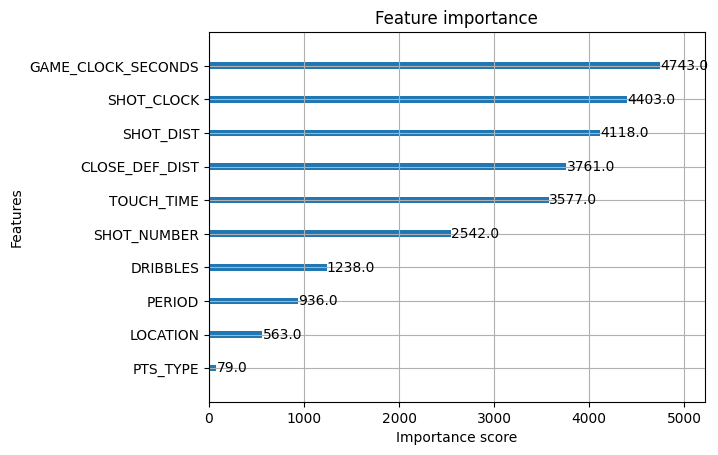

In [25]:
xgb.plot_importance(xgb_model)
